In [32]:
#!pip install -U -q segmentation-models --user

from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#os.environ["SM_FRAMEWORK"] = "tf.keras"

#import segmentation_models as sm
import matplotlib.pyplot as plt 
#import tensorflow_io as tfio
import tensorflow as tf


import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, UpSampling2D, concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from skimage.io import imread
from skimage.transform import resize

root = '../input/retinal-vessel-segmentation'
exts = ('jpg', 'JPG', 'png', 'PNG', 'tif', 'gif', 'ppm')

In [58]:
# Load images and masks
train_images = []  # List to store training images
train_masks = []   # List to store trianing masks
test_images = []   # List to store test images
test_masks = []    # List to store test masks
manual_segment = []    # List to store manually segmented masks 

path = 'DRIVE/'

from skimage.util import img_as_ubyte, invert

# Load images and masks from your dataset
for i in range(21, 41):
    # Load images from the first dataset
    img = imread(path + 'training/images/{}_training.tif'.format(i), as_gray=False)
    train_images.append(img)

for i in range(21, 22):
    # Load images from the first dataset
    mask = img_as_ubyte(imread(path + 'training/mask/{}_training_mask.tif'.format(i), as_gray=False))
    train_masks.append(mask)


# Resize images and masks
image_size = (256, 256)  # Desired image size
train_images_resized = [resize(img, image_size) for img in train_images]
train_masks_resized = [resize(mask, image_size) for mask in train_masks]
#preserve_range=True).astype(np.uint8)
# Normalize pixel values
#train_images_normalized = [img / 255.0 for img in train_images_resized]


(256, 256, 3)


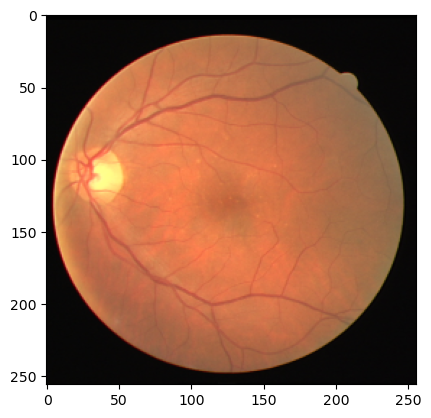

In [59]:
plt.imshow(train_images_resized[0])
print(train_images_resized[0].shape)

(256, 256, 4)


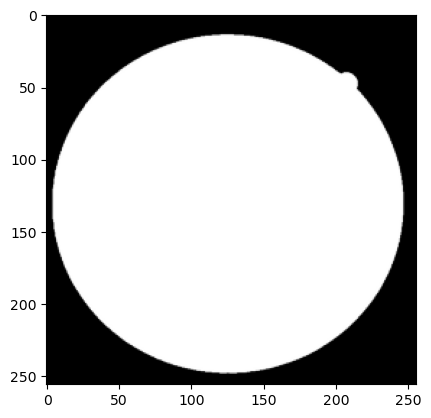

In [60]:
plt.imshow(train_masks_resized[0])
print(train_masks_resized[0].shape)

In [33]:
def unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    up1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up1 = concatenate([up1, conv2], axis=3)

    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up2 = concatenate([up2, conv1], axis=3)

    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define input shape
input_shape = (256, 256, 3)

# Create the model
model = unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d_6[0][0]']            
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_7[0][0]']            
 g2D)                                                                                        

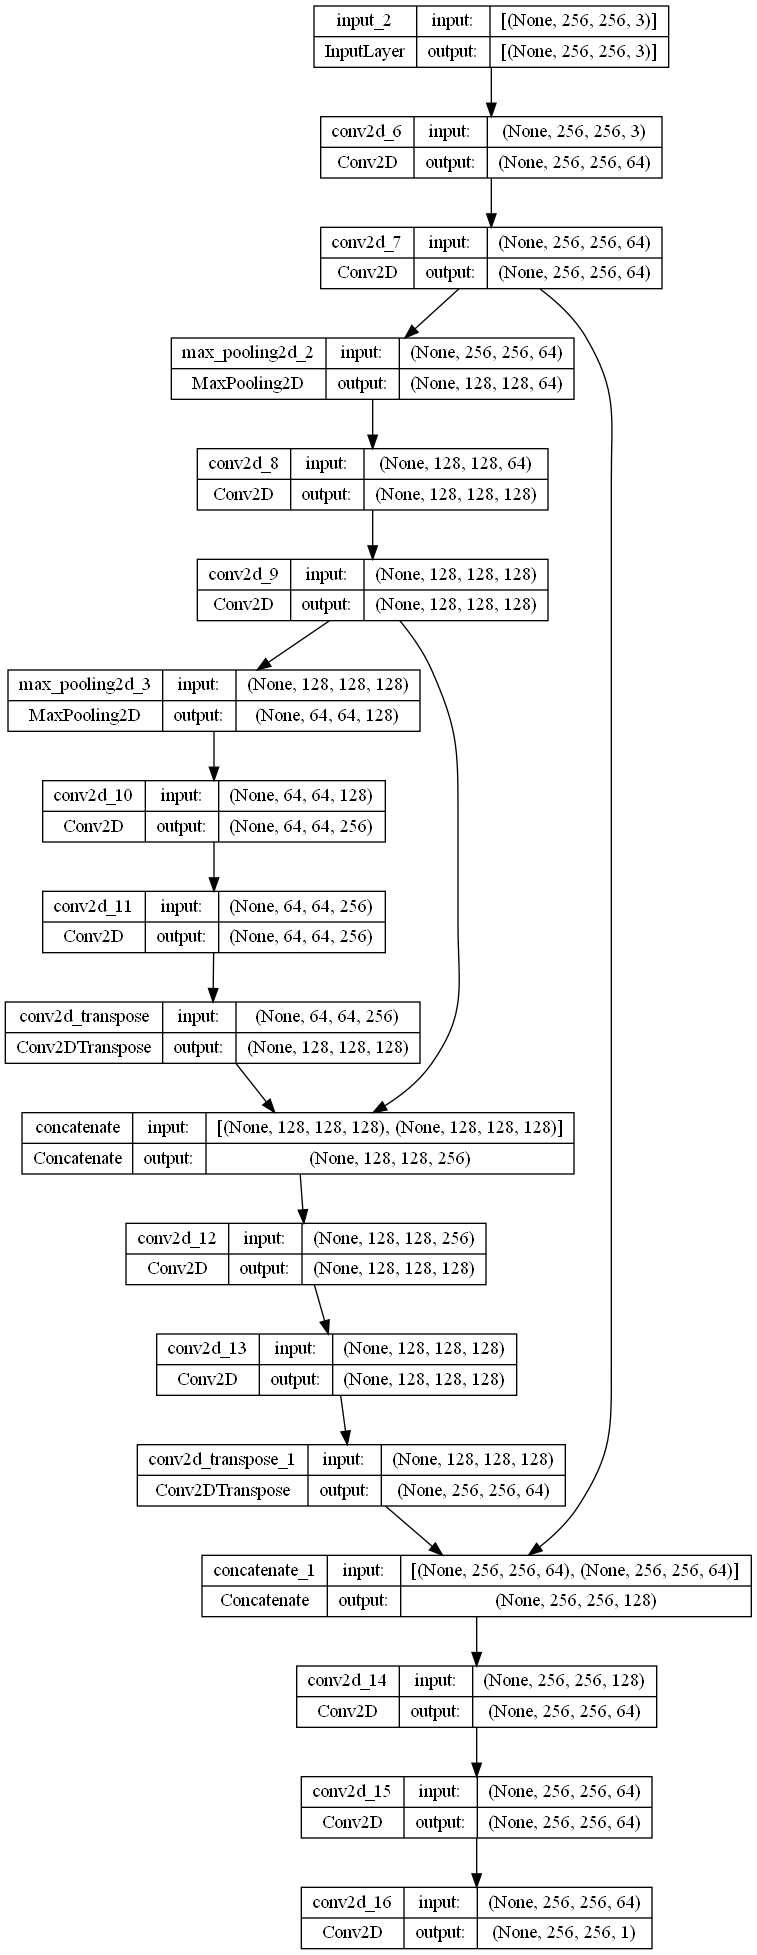

In [47]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96
)

In [62]:
EPOCHS = 30
BUFFER_SIZE = 32
BATCH_SIZE = 6

# train_processed_image_ds.batch(BATCH_SIZE)
# test_processed_image_ds.batch(BATCH_SIZE)

train_dataset = train_images_resized[0]
#test_dataset = test_images_resized


#print(test_processed_image_ds.element_spec)
# model_history = unet.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, verbose=1)
model_history = model.fit(train_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/30


ValueError: in user code:

    File "c:\Users\chris\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\chris\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\chris\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\chris\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\chris\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\chris\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 256, 3)
